# Gradient Boosted Trees (GBT) & Analytics Workload Experiment setup

- Date: 22.09.2021
- Execution: DOS ARM Spark K8s cluster
- Checkpoint Interval: every 5 iterations
- Only the Analytics workloads wrote files on HDFS
- The Analytics workload only ran once since I'm not expecting a huge variance due to no changing input parameters

| **Workload App**         | **Checkpoint**     | **Input size** | **Drivers**         | **Driver Cores**     |**Driver Memory** |**Executors** |**Executors Cores** |**Executors Memory** |**Iterations** | **Checkpoint size** |
|--------------|-----------|------------|--------------|-----------|------------|------------|------------|------------|------------|------------|
| gbt-9000000-10 | NO      | 1.6 GB        | 1 | 4      | 4 GB        | 4        | 4        | 2 GB    |20        | / |
| gbt-9000000-10-checkpoint      | YES  | 1.6 GB       | 1      | 4  | 4 GB       | 4        | 4        | 2 GB | 20 | 0  |
| analytics-1gb      | NO  | 1 GB       | 1      | 4  | 4 GB       | 4        | 4        | 2 GB | 1  | /  |
| analytics-1gb-checkpoint | YES  | 1 GB       | 1      | 4  | 4 GB       | 4        | 4        | 2 GB | 1 | 1.2GB


# 1. Analysis

## 1.1 Data preparation

In [1]:
from pyspark.sql import types as T
from pyspark.sql import functions as F
from pyspark.sql import DataFrame

In [2]:
gbt_df = spark.read.csv(
    path="../output/cluster/GradientBoostedTrees/spark-d442e8781ae944f181fd4c5e555e4ccc_normal.csv",
    sep=",",
    header=True,
    inferSchema=True
)

In [3]:
gbt_check_df = spark.read.csv(
    path="../output/cluster/GradientBoostedTrees/spark-5852506aefd747988e6e3e4545f09fbd_checkpoint.csv",
    sep=",",
    header=True,
    inferSchema=True
)

In [127]:
analytics_df = spark.read.csv(
    path="../output/cluster/Analytics/spark-86c258cf3ff643fc97eb5734f1c6b966_normal.csv",
    sep=",",
    header=True,
    inferSchema=True
)

In [128]:
analytics_check_df = spark.read.csv(
    path="../output/cluster/Analytics/spark-51240c47278f4aca937cb63709fb3516_checkpoint.csv",
    sep=",",
    header=True,
    inferSchema=True
)

In [4]:
def cast(gbt_df: DataFrame) -> DataFrame:
    # cast numeric and datetime columns
    datetime_pattern = "yyyy-MM-dd'T'HH:mm:ss.SSSz"

    gbt_df = gbt_df.select(
        "*",
        gbt_df.taskIndex.cast(T.IntegerType()).alias("taskIndex_"),
        gbt_df.rddId.cast(T.IntegerType()).alias("rddId_"),
        gbt_df.taskAttempt.cast(T.IntegerType()).alias("taskAttempt_"),
        gbt_df.taskDuration.cast(T.FloatType()).alias("taskDuration_"),
        gbt_df.taskExecutorId.cast(T.IntegerType()).alias("taskExecutorId_"),
        gbt_df.tcMs.cast(T.FloatType()).alias("tcMs_"),
        F.to_timestamp(gbt_df.submissionTime, datetime_pattern).alias("submissionTime_"),
        F.to_timestamp(gbt_df.firstTaskLaunchedTime, datetime_pattern).alias("firstTaskLaunchedTime_"),
        F.to_timestamp(gbt_df.completionTime, datetime_pattern).alias("completionTime_"),
        F.to_timestamp(gbt_df.taskLaunchTime, datetime_pattern).alias("taskLaunchTime_")
    ).drop("taskIndex", "rddId", "taskId", "tcMs",
           "taskAttempt", "taskDuration", "taskExecutorId", "submissionTime",
           "firstTaskLaunchedTime", "completionTime", "taskLaunchTime")
    
    # rename columns
    new_column_names = [c.rstrip("_") for c in gbt_df.columns]
    gbt_df = gbt_df.toDF(*new_column_names)

    gbt_df = gbt_df.withColumnRenamed("_c0", "id")
    
    return gbt_df

In [5]:
gbt_df = cast(gbt_df)

In [6]:
gbt_df

DataFrame[id: int, status: string, stageId: int, attemptId: int, numTasks: int, numActiveTasks: int, numCompleteTasks: int, numFailedTasks: int, numKilledTasks: int, name: string, rddIds: string, taskIndex: int, rddId: int, taskAttempt: int, taskDuration: float, taskExecutorId: int, tcMs: float, submissionTime: timestamp, firstTaskLaunchedTime: timestamp, completionTime: timestamp, taskLaunchTime: timestamp]

In [7]:
gbt_check_df = cast(gbt_check_df)

In [129]:
analytics_df = cast(analytics_df)

In [131]:
analytics_df

DataFrame[id: int, status: string, stageId: int, attemptId: int, numTasks: int, numActiveTasks: int, numCompleteTasks: int, numFailedTasks: int, numKilledTasks: int, name: string, rddIds: string, taskIndex: int, rddId: int, taskAttempt: int, taskDuration: float, taskExecutorId: int, tcMs: float, submissionTime: timestamp, firstTaskLaunchedTime: timestamp, completionTime: timestamp, taskLaunchTime: timestamp]

In [130]:
analytics_check_df = cast(analytics_check_df)

## 1.2 Data summary

### `GBT`
- 16 as maximum for `numCompleteTasks` make sense since 4 executors with 4 cores each can compute maximum 16 tasks in parallel
- 4 as maximum for `numFailedTasks` means that no cores were available anymore, thus the executor failed

In [97]:
gbt_df.select("numCompleteTasks", "numFailedTasks", "numKilledTasks", "taskAttempt", "taskDuration").summary().show()

+-------+------------------+--------------------+--------------+--------------------+------------+
|summary|  numCompleteTasks|      numFailedTasks|numKilledTasks|         taskAttempt|taskDuration|
+-------+------------------+--------------------+--------------+--------------------+------------+
|  count|            409860|              409860|        409860|                2530|      409860|
|   mean|15.592592592592593|0.024691358024691357|           0.0|0.001581027667984...|         NaN|
| stddev| 2.273183922465939|  0.3132985930774935|           0.0|0.039738547914128335|         NaN|
|    min|                 1|                   0|             0|                   0|         9.0|
|    25%|                16|                   0|             0|                   0|         NaN|
|    50%|                16|                   0|             0|                   0|         NaN|
|    75%|                16|                   0|             0|                   0|         NaN|
|    max| 

In [99]:
gbt_check_df.select("numCompleteTasks", "numFailedTasks", "numKilledTasks", "taskAttempt", "taskDuration", "tcMs").summary().show()

+-------+------------------+-------------------+--------------+--------------------+------------+------+
|summary|  numCompleteTasks|     numFailedTasks|numKilledTasks|         taskAttempt|taskDuration|  tcMs|
+-------+------------------+-------------------+--------------+--------------------+------------+------+
|  count|            708292|             708292|        708292|                3341|      708292|708292|
|   mean|15.702830188679245|0.05660377358490566|           0.0|0.003591739000299...|         NaN|   NaN|
| stddev|1.9861305446767186| 0.6116821328367202|           0.0| 0.05983234843927994|         NaN|   NaN|
|    min|                 1|                  0|             0|                   0|         9.0|1121.0|
|    25%|                16|                  0|             0|                   0|         NaN|3090.0|
|    50%|                16|                  0|             0|                   0|         NaN|1801.0|
|    75%|                16|                  0|       

### `Analytics`
- higher number of tasks per stage
- no failed or killed tasks
- higher task and checkpoint duration than `GBT`

In [133]:
analytics_df.select("numCompleteTasks", "numFailedTasks", "numKilledTasks", "taskAttempt", "taskDuration", "tcMs").summary().show()

+-------+-----------------+--------------+--------------+-----------+------------+----+
|summary| numCompleteTasks|numFailedTasks|numKilledTasks|taskAttempt|taskDuration|tcMs|
+-------+-----------------+--------------+--------------+-----------+------------+----+
|  count|              696|           696|           696|        232|         696| 696|
|   mean|77.33333333333333|           0.0|           0.0|        0.0|         NaN| NaN|
| stddev|86.80081114452626|           0.0|           0.0|        0.0|         NaN| NaN|
|    min|               16|             0|             0|          0|        93.0| NaN|
|    25%|               16|             0|             0|          0|       249.0| NaN|
|    50%|               16|             0|             0|          0|         NaN| NaN|
|    75%|              200|             0|             0|          0|         NaN| NaN|
|    max|              200|             0|             0|          0|         NaN| NaN|
+-------+-----------------+-----

In [132]:
analytics_check_df.select("numCompleteTasks", "numFailedTasks", "numKilledTasks", "taskAttempt", "taskDuration", "tcMs").summary().show()

+-------+-----------------+--------------+--------------+-----------+------------+------+
|summary| numCompleteTasks|numFailedTasks|numKilledTasks|taskAttempt|taskDuration|  tcMs|
+-------+-----------------+--------------+--------------+-----------+------------+------+
|  count|             5976|          5976|          5976|        664|        5976|  5976|
|   mean|73.77777777777777|           0.0|           0.0|        0.0|         NaN|   NaN|
| stddev|89.47228727717322|           0.0|           0.0|        0.0|         NaN|   NaN|
|    min|                0|             0|             0|          0|        73.0|8027.0|
|    25%|               16|             0|             0|          0|         NaN|   NaN|
|    50%|               16|             0|             0|          0|         NaN|   NaN|
|    75%|              200|             0|             0|          0|         NaN|   NaN|
|    max|              200|             0|             0|          0|         NaN|   NaN|
+-------+-

### *Finding 1*: `gbt-9000000-10-checkpoint` has almost double the amount of tasks and failed tasks than  `gbt-9000000-10`

In [8]:
gbt_check_df.select("tcMs", "rddId").distinct().sort("rddId").show(10)

+------+-----+
|  tcMs|rddId|
+------+-----+
|   NaN| null|
|1801.0|  134|
|1121.0|  245|
|3090.0|  356|
+------+-----+



In [147]:
analytics_check_df.select("tcMs", "rddId").distinct().sort("rddId").show(10)

+------+-----+
|  tcMs|rddId|
+------+-----+
|   NaN| null|
|8027.0|   14|
+------+-----+



### *Finding 2*: Over time, the `tcMs` does not seem to increase

### *Question 1*: with 20 iterations and an interval of 5, why were there 3 and not 4 checkpoints?

### *Plot 1*: total App runtime compared

In [142]:
gbt_runtime = gbt_df.select(
    F.min("submissionTime").alias("start"),
    F.max("completionTime").alias("end"),
    (F.max("completionTime").cast(T.LongType()) - F.min("submissionTime").cast(T.LongType())).alias("duration")  # in seconds
).select("duration").collect()[0][0] / 60

analytics_runtime = analytics_df.select(
    F.min("submissionTime").alias("start"),
    F.max("completionTime").alias("end"),
    (F.max("completionTime").cast(T.LongType()) - F.min("submissionTime").cast(T.LongType())).alias("duration")  # in seconds
).select("duration").collect()[0][0] / 60

gbt_check_runtime = gbt_check_df.select(
    F.min("submissionTime").alias("start"),
    F.max("completionTime").alias("end"),
    (F.max("completionTime").cast(T.LongType()) - F.min("submissionTime").cast(T.LongType())).alias("duration")  # in seconds
).select("duration").collect()[0][0] / 60

analytics_check_runtime = analytics_check_df.select(
    F.min("submissionTime").alias("start"),
    F.max("completionTime").alias("end"),
    (F.max("completionTime").cast(T.LongType()) - F.min("submissionTime").cast(T.LongType())).alias("duration")  # in seconds
).select("duration").collect()[0][0] / 60

gbt_distinct_tcms = gbt_check_df.filter(~F.isnan(F.col("tcMs"))).select("tcMs").distinct()
gbt_tcMs_sum_seconds = distinct_tcms.select((F.sum(F.col("tcMs")) / 1000).alias("tcMsSumSeconds")).collect()[0][0]

analytics_distinct_tcms = analytics_check_df.filter(~F.isnan(F.col("tcMs"))).select("tcMs").distinct()
analytics_tcMs_sum_seconds = analytics_distinct_tcms.select((F.sum(F.col("tcMs")) / 1000).alias("tcMsSumSeconds")).collect()[0][0]

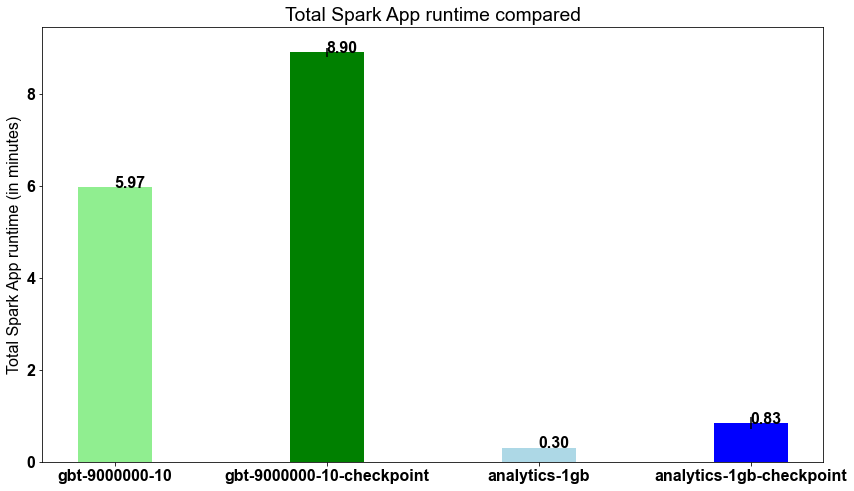

In [144]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

font = {'family' : 'arial',
        'weight' : 'bold',
        'size'   : 16}

plt.rc('font', **font)


labels = ['gbt-9000000-10', 'gbt-9000000-10-checkpoint', 'analytics-1gb', 'analytics-1gb-checkpoint']


runtimes = [gbt_runtime, gbt_check_runtime, analytics_runtime, analytics_check_runtime,]

yerrs = [0, (gbt_tcMs_sum_seconds / 60), 0, (analytics_tcMs_sum_seconds / 60) ]


fig, ax = plt.subplots()
fig.set_size_inches(14, 8)

#
ax.bar(labels, runtimes, width, label='App runtime (in minutes)', yerr=yerrs, color=["lightgreen", "green", "lightblue", "blue"])

# annotate the values to the bars
for i,j in zip(labels,runtimes):
    ax.annotate(str(format(j, '.2f')),xy=(i,j))

ax.set_ylabel('Total Spark App runtime (in minutes)')
ax.set_title('Total Spark App runtime compared')

plt.show()

### *Finding 3*: The App runtime difference is much larger than the time the checkpointing took:

In [145]:
gbt_tcMs_sum_seconds

6.012

In [146]:
analytics_tcMs_sum_seconds

8.027

### *Question  2*: How can this be explained? What happened in the remaining time?

### *Plot 2*: GBT `tcMs` over time

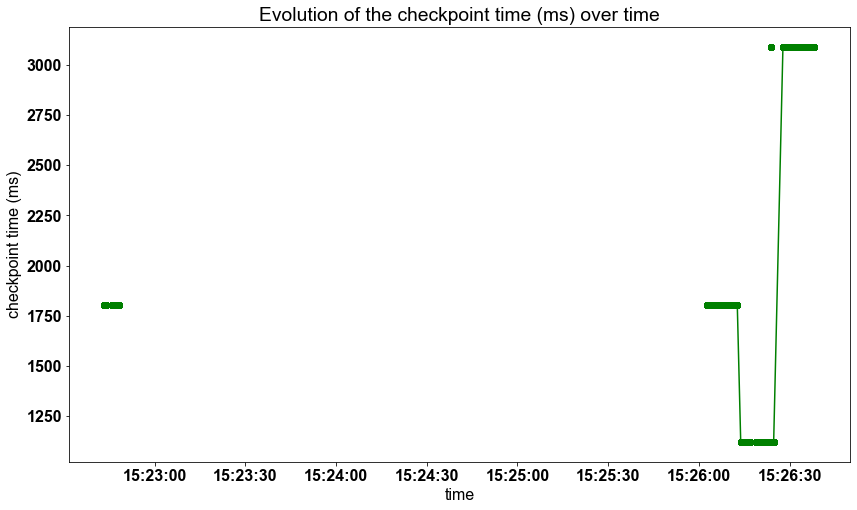

In [164]:
gbt_check_submission_time = gbt_check_df.select("submissionTime").toPandas()["submissionTime"]
gbt_tc_ms = gbt_check_df.select("tcMs").toPandas()["tcMs"]

fig = plt.figure(figsize=(14, 8))

plt.plot(gbt_check_submission_time, tc_ms, '-o', color="green")

plt.xlabel('time')
plt.ylabel('checkpoint time (ms)')
plt.title('Evolution of the checkpoint time (ms) over time')

plt.show()

### *Plot 3*: Analytics `tcMs` over time

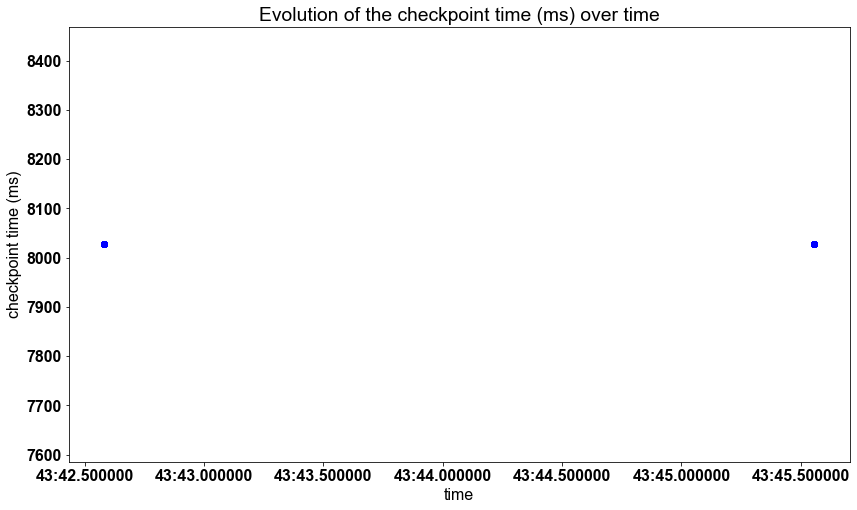

In [166]:
analytics_check_submission_time = analytics_check_df.select("submissionTime").toPandas()["submissionTime"]
analytics_tc_ms = analytics_check_df.select("tcMs").toPandas()["tcMs"]

fig = plt.figure(figsize=(14, 8))

plt.plot(analytics_check_submission_time, analytics_tc_ms, '-o', color="blue")

plt.xlabel('time')
plt.ylabel('checkpoint time (ms)')
plt.title('Evolution of the checkpoint time (ms) over time')

plt.show()

### *Plot 3*: GBT: Failed and completed tasks per stage over time

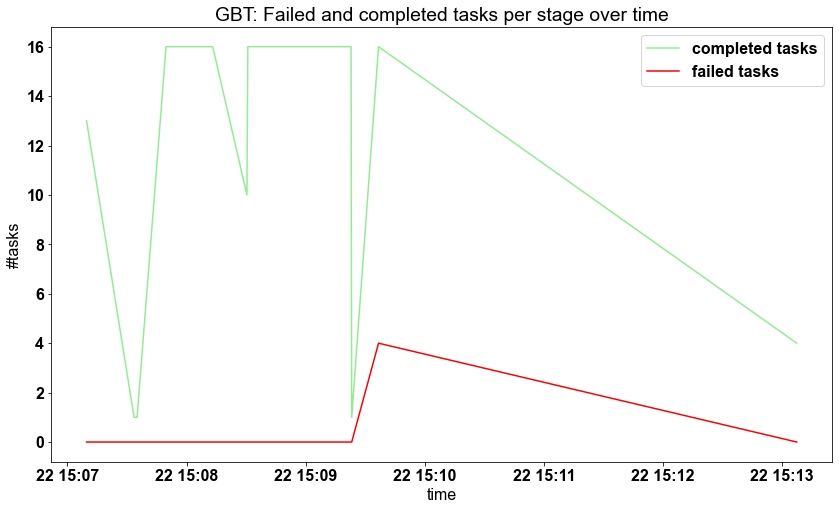

In [160]:
gbt_submission_time = gbt_df.select("submissionTime").toPandas()["submissionTime"]

gbt_complete_tasks = gbt_df.select("numCompleteTasks").toPandas()["numCompleteTasks"]
gbt_failed_tasks = gbt_df.select("numFailedTasks").toPandas()["numFailedTasks"]

gbt_check_complete_tasks = gbt_check_df.select("numCompleteTasks").toPandas()["numCompleteTasks"]
gbt_check_failed_tasks = gbt_check_df.select("numFailedTasks").toPandas()["numFailedTasks"]


fig = plt.figure(figsize=(14, 8))

plt.plot(gbt_submission_time, gbt_complete_tasks, color="lightgreen", label="completed tasks")
plt.plot(gbt_submission_time, gbt_failed_tasks, color="red", label="failed tasks")

plt.xlabel('time')
plt.ylabel('#tasks')
plt.title('GBT: Failed and completed tasks per stage over time')
plt.legend()

plt.show()

### *Plot 4*: GBT: Failed and completed tasks per stage over time (with checkpoint)

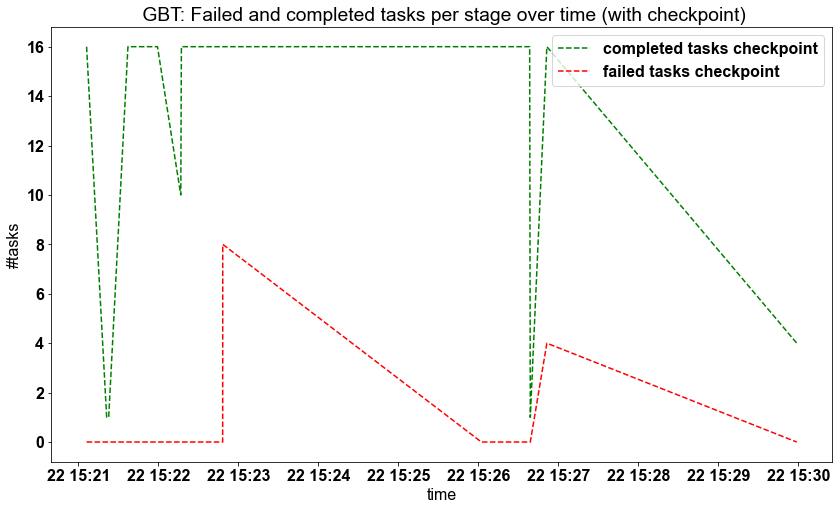

In [159]:
gbt_check_submission_time = gbt_check_df.select("submissionTime").toPandas()["submissionTime"]

gbt_check_complete_tasks = gbt_check_df.select("numCompleteTasks").toPandas()["numCompleteTasks"]
gbt_check_failed_tasks = gbt_check_df.select("numFailedTasks").toPandas()["numFailedTasks"]


fig = plt.figure(figsize=(14, 8))

plt.plot(gbt_check_submission_time, gbt_check_complete_tasks, color="green", linestyle="dashed", label="completed tasks checkpoint")
plt.plot(gbt_check_submission_time, gbt_check_failed_tasks, color="red", linestyle="dashed", label="failed tasks checkpoint")

plt.xlabel('time')
plt.ylabel('#tasks')
plt.title(' GBT: Failed and completed tasks per stage over time (with checkpoint)')
plt.legend()

plt.show()

### *Plot 6*: Analytics: Failed and completed tasks per stage over time (with checkpoint)
- number of tasks completed grows linearly without any failures

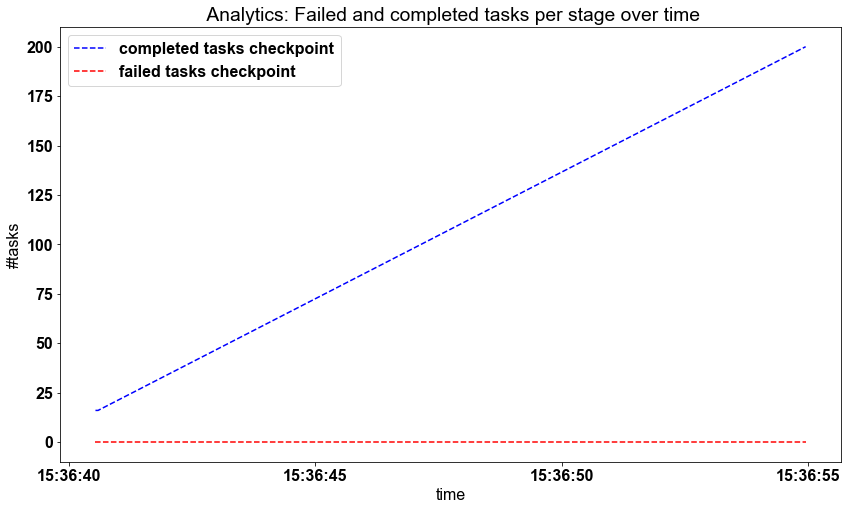

In [167]:
analytics_submission_time = analytics_df.select("submissionTime").toPandas()["submissionTime"]

analytics_complete_tasks = analytics_df.select("numCompleteTasks").toPandas()["numCompleteTasks"]
analytics_failed_tasks = analytics_df.select("numFailedTasks").toPandas()["numFailedTasks"]


fig = plt.figure(figsize=(14, 8))

plt.plot(analytics_submission_time, analytics_complete_tasks, color="blue", linestyle="dashed", label="completed tasks checkpoint")
plt.plot(analytics_submission_time, analytics_failed_tasks, color="red", linestyle="dashed", label="failed tasks checkpoint")

plt.xlabel('time')
plt.ylabel('#tasks')
plt.title(' Analytics: Failed and completed tasks per stage over time')
plt.legend()

plt.show()

### *Plot 7*: Analytics: Failed and completed tasks per stage over time (with checkpoint)

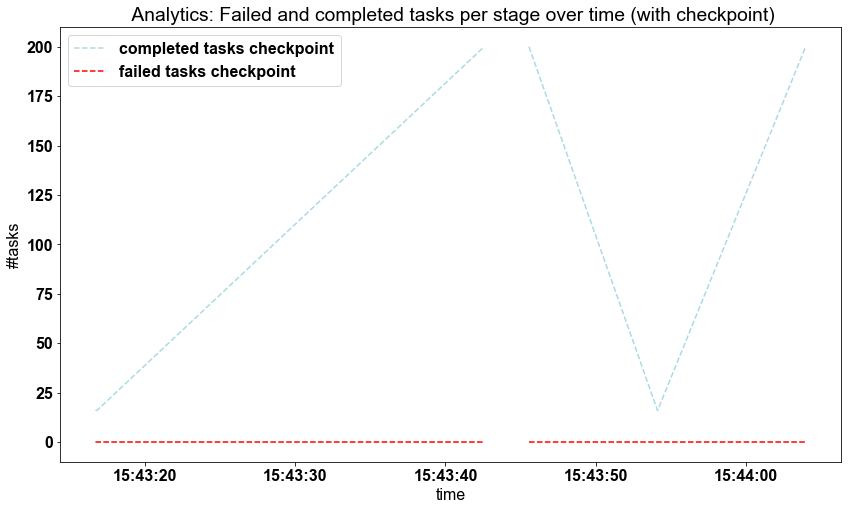

In [162]:
analytics_check_submission_time = analytics_check_df.select("submissionTime").toPandas()["submissionTime"]

analytics_check_complete_tasks = analytics_check_df.select("numCompleteTasks").toPandas()["numCompleteTasks"]
analytics_check_failed_tasks = analytics_check_df.select("numFailedTasks").toPandas()["numFailedTasks"]


fig = plt.figure(figsize=(14, 8))

plt.plot(analytics_check_submission_time, analytics_check_complete_tasks, color="lightblue", linestyle="dashed", label="completed tasks checkpoint")
plt.plot(analytics_check_submission_time, analytics_check_failed_tasks, color="red", linestyle="dashed", label="failed tasks checkpoint")

plt.xlabel('time')
plt.ylabel('#tasks')
plt.title(' Analytics: Failed and completed tasks per stage over time (with checkpoint)')
plt.legend()

plt.show()

### Finding 4: Once there is the checkpoint at *15:43:50* (see Plot 3 above), the number of tasks to complete drops to 0 because the RDD lineage is truncated!